<a href="https://colab.research.google.com/github/kimchaeyoung-student/pdm04/blob/master/py-tensorflow/tf2_3_mnist_NN_good.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Keras example: mnist analysisby simple NN (Neural network)

- Keras was designed to easily use the famous deep-learning frameworks; tensorflow, tenano. 
- Keras provides an easy and convenient way to build deep learning models.

    - Keras is an open source python library that enables you to easily build Deep Neural Networks. 
    - This library is implemented in TensorFlow 2.0.
    - Tensorflow and Pytorch are the most used numerical platforms in Python to build Deep Learning algorithms.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.3.0


In [2]:
%%time
from keras.datasets import mnist
(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step
CPU times: user 327 ms, sys: 68.6 ms, total: 396 ms
Wall time: 488 ms


In [3]:
print(X_train0.shape, X_train0.dtype)
print(y_train0.shape, y_train0.dtype)
print(X_test0.shape, X_test0.dtype)
print(y_test0.shape, y_test0.dtype)

(60000, 28, 28) uint8
(60000,) uint8
(10000, 28, 28) uint8
(10000,) uint8


1334


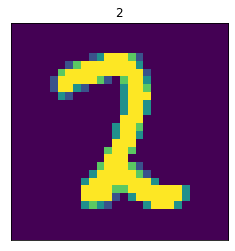

In [4]:
# display one random image from the training set:
class_names = ["0","1","2","3","4","5","6","7","8","9"]

idx = np.random.randint(0, X_train0.shape[0])
print(idx)
image = X_train0[idx]
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[y_train0[idx]])
plt.xticks([])
plt.yticks([])
plt.show()

### Show images of numbers

(5923, 28, 28)
(6742, 28, 28)
(5958, 28, 28)
(6131, 28, 28)
(5842, 28, 28)
(5421, 28, 28)
(5918, 28, 28)
(6265, 28, 28)
(5851, 28, 28)
(5949, 28, 28)


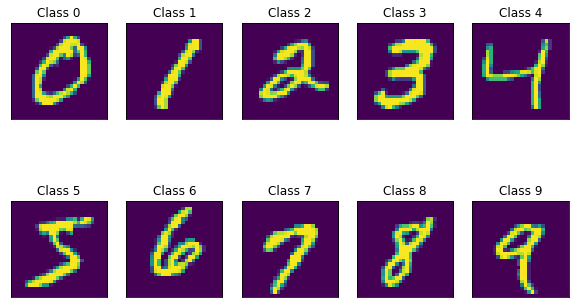

In [5]:
fig = plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    num0_9 = X_train0[y_train0 == i]
    print(num0_9.shape)
    plt.imshow(num0_9[0]) #, cmap='gray') #, interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])


### 데이터를 float 타입으로 바꾸고 스케일링한다.
- 2차원 영상을 1차원 벡터로 변환
- (28,28) => (784,)
- Scaling: (0 ~ 255)/255.0

In [6]:
X_train = X_train0.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test0.reshape(10000, 784).astype('float32') / 255.0
print(X_train.shape, X_train.dtype)
print(X_test.shape, X_test.dtype)

(60000, 784) float32
(10000, 784) float32


In [7]:
print(X_train0.shape, X_train.shape)

(60000, 28, 28) (60000, 784)


### y 데이터는 One-Hot-Encoding 을 한다.

In [8]:
y_train0[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [9]:
# Use function to_categorical() to do One-Hot-Encoding
# tf.keras.utils.to_categorical
from keras.utils import to_categorical

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
y_train[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

> One-Hot-Encoding을 하는 이유
- 머신러닝의 목표가 특정 숫자 그림의 숫자를 정확하게 맞추는 것이 아니다.
    1. 일단, 0에서 9까지의 숫자로 판단될 10개의 확률을 계산한다.
    2. 그리고 특정 숫자로 판단될 확률이 제일 큰 수로 결정한다.
- 3개 이상의 클래스를 구분하는 지도학습의 경우 One-Hot-Encoding은 필요한 과정이다.



---



---



# 신경망 (Neural network)

## 신경망 구현 순서

### Keras 를 사용하면 다음과 같은 순서로 신경망을 구성할 수 있다.

1. **모형 객체 생성**, Sequential 모형 클래스 객체 생성
2. **신경망 구성**, layer 추가하여 구성
    - Dense layer 가 가장 일반적인 신경망
    - 입력단부터 순차적으로 추가한다.
    - 레이어는 출력 뉴런 갯수를 첫번째 인수로 받는다.
    - 최초의 레이어는 input_shape 인수로 입력 크기를 설정해야 한다.
    - activation 인수로 activation 함수 설정
3. **compile** 메서드로 모형 완성.
    - loss 인수로 Loss 함수 설정
    - optimizer 인수로 최적화 알고리즘 설정
    - metrics 인수로 트레이닝 단계에서 기록할 성능 기준 설정
4. **fit** 메서드로 트레이닝
    - epochs로 트레이닝 횟수 설정
    - batch_size 로 mini batch size 설정
    - metrics 인수로 설정한 성능 기준 기록을 출력으로 반환

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

## Starting model
> 784개의 입력을 받는 하나의 hidden layer(16 neurons)와 출력레이어(10 neurons)로 구성된 단순한 신경망.

In [12]:
# Configure model
# np.random.seed(0)
tf.random.set_seed(0)

model = Sequential()
model.add(Dense(16, input_dim=784, activation="sigmoid"))  # first layer
model.add(Dense(10, activation="softmax")) # output layer

![mnist_NN_2_layers](https://raw.githubusercontent.com/Redwoods/Py/master/pdm2020/my-note/py-tensorflow/images/mnist_NN_2_layers.png)


### Model 정보 및 출력
- summary()
- plot_model()

In [13]:
# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


In [14]:
# check parameters
28*28*16+16, 16*10+10

(12560, 170)

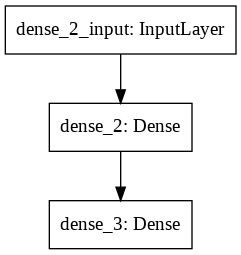

In [15]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

### 모델의 구조 살펴 보기

In [16]:
model

In [17]:
model.get_config()

{'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 784),
    'dtype': 'float32',
    'name': 'dense_2_input',
    'ragged': False,
    'sparse': False}},
  {'class_name': 'Dense',
   'config': {'activation': 'sigmoid',
    'activity_regularizer': None,
    'batch_input_shape': (None, 784),
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'kernel_regularizer': None,
    'name': 'dense_2',
    'trainable': True,
    'units': 16,
    'use_bias': True}},
  {'class_name': 'Dense',
   'config': {'activation': 'softmax',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_ini

In [18]:
l1 = model.layers[0]
l2 = model.layers[1]

In [19]:
l1.name, type(l1), l1.output_shape, l1.activation.__name__, l1.count_params()

('dense_2',
 tensorflow.python.keras.layers.core.Dense,
 (None, 16),
 'sigmoid',
 12560)

In [20]:
# number of parameters
784*16 + 16

12560

In [21]:
l2.name, type(l1), l2.output_shape, l2.activation.__name__, l2.count_params()

('dense_3',
 tensorflow.python.keras.layers.core.Dense,
 (None, 10),
 'softmax',
 170)

In [22]:
# number of parameters
16*10 + 10  

170

## fit 메서드로 트레이닝

- [optimizers](https://wiserloner.tistory.com/1032)
- [GD, SGD](https://seamless.tistory.com/38)

In [23]:
# Select an optimizer, loss='mean squared error' => 
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
%%time
hist = model.fit(X_train, y_train, 
                 epochs=20, batch_size=100, 
                 validation_data=(X_test, y_test), 
                 verbose=1)


# batch_size: 100 -> 60,000개의 트레이닝 데이터를 100개씩 600묶음으로 나눈 후, 
# 각 묶음에 대하어 forward, back propagation을 실시하면서 파라미터를 조정한다.
# epochs: 전체 600개의 batch에 대하여 다 계산을 수행하면 epoch 1 종료.
# validation_data: 테스트 데이터를 섞어서 검증한다.

Epoch 1/20
600/600 [==============================] - 1s 2ms/step - loss: 2.1406 - accuracy: 0.3920 - val_loss: 1.9192 - val_accuracy: 0.6008
Epoch 2/20
600/600 [==============================] - 1s 2ms/step - loss: 1.7704 - accuracy: 0.6295 - val_loss: 1.6097 - val_accuracy: 0.6683
Epoch 3/20
600/600 [==============================] - 1s 2ms/step - loss: 1.4958 - accuracy: 0.6828 - val_loss: 1.3628 - val_accuracy: 0.7226
Epoch 4/20
600/600 [==============================] - 1s 2ms/step - loss: 1.2769 - accuracy: 0.7377 - val_loss: 1.1697 - val_accuracy: 0.7708
Epoch 5/20
600/600 [==============================] - 1s 2ms/step - loss: 1.1071 - accuracy: 0.7797 - val_loss: 1.0217 - val_accuracy: 0.8064
Epoch 6/20
600/600 [==============================] - 1s 2ms/step - loss: 0.9775 - accuracy: 0.8035 - val_loss: 0.9091 - val_accuracy: 0.8242
Epoch 7/20
600/600 [==============================] - 1s 2ms/step - loss: 0.8781 - accuracy: 0.8195 - val_loss: 0.8222 - val_accuracy: 0.8382
Epoch 

### Plot of performance and accuracy (모델 성능 및 정확도)

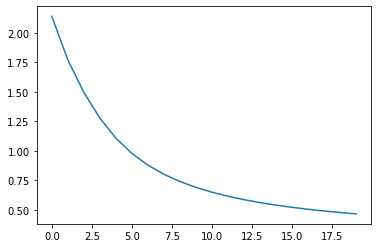

In [25]:
# Plot performance
plt.plot(hist.history['loss'])
plt.show()

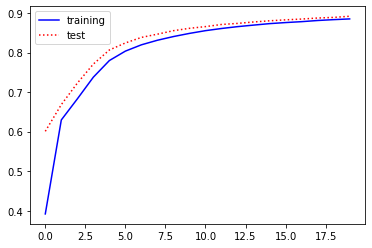

In [26]:
plt.plot(hist.history['accuracy'], 'b-', label="training")
plt.plot(hist.history['val_accuracy'], 'r:', label="test")
plt.legend()
plt.show()

## 가중치 정보

> 트레이닝이 끝난 모형의 가중치 정보는 get_weights 메서드로 구할 수 있다. 이 메서드는 w 값과 b 값을 출력한다.
- w: weights
- b: bias

In [27]:
w1 = l1.get_weights()  # 784*16 + 16 = 12560
w1[0].shape, w1[1].shape

((784, 16), (16,))

In [28]:
w2 = l2.get_weights()  # 16*10 + 10 = 170
w2[0].shape, w2[1].shape

((16, 10), (10,))

## 모형의 사용

> 트레이닝이 끝난 모형은 predict 메서드로 y 값을 출력하거나 출력된 y값을 각 클래스에 대한 판별함수로 가정하고 predict_classes 메서드로 classification을 할 수 있다.

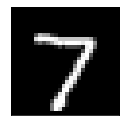

In [29]:
plt.figure(figsize=(2, 2))
plt.imshow(X_test0[0], cmap='gray')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

In [30]:
X_test[:1, :].shape

(1, 784)

In [31]:
model.predict(X_test[:1, :])  # Probabilitic prediction viq one-hot encoding of labels

array([[5.7687284e-03, 5.8509986e-04, 2.1284637e-03, 9.9441223e-03,
        2.2075614e-03, 3.8659077e-03, 5.3860844e-05, 9.2814851e-01,
        1.2815687e-03, 4.6016149e-02]], dtype=float32)

In [32]:
tf.argmax(model.predict(X_test[:1, :]),axis=1), np.argmax(model.predict(X_test[:1, :]),axis=1)

(<tf.Tensor: shape=(1,), dtype=int64, numpy=array([7])>, array([7]))

### 테스트 데이터에 대한 예측 정확도 계산 

In [33]:
y_pred0 = model.predict(X_test, verbose=1)
y_pred0[:5]

313/313 [==============================] - 0s 927us/step


array([[5.7687284e-03, 5.8509986e-04, 2.1284637e-03, 9.9441269e-03,
        2.2075614e-03, 3.8659077e-03, 5.3860844e-05, 9.2814851e-01,
        1.2815687e-03, 4.6016160e-02],
       [1.0662109e-01, 4.4235189e-02, 4.2050284e-01, 8.5213304e-02,
        3.0030352e-03, 6.3173093e-02, 2.4739215e-01, 2.4471262e-03,
        2.4066854e-02, 3.3452462e-03],
       [1.0694849e-03, 9.1094279e-01, 1.8342238e-02, 1.0122690e-02,
        3.9279964e-03, 2.3546223e-02, 3.0247255e-03, 7.6030567e-03,
        1.3332549e-02, 8.0882506e-03],
       [9.6336716e-01, 2.3024312e-04, 5.6921928e-03, 3.5991273e-03,
        2.4348780e-04, 1.4768733e-02, 6.3970420e-03, 4.9819052e-03,
        5.2158581e-04, 1.9852040e-04],
       [1.2278183e-03, 1.8395851e-03, 1.4536968e-02, 1.8918680e-03,
        7.3505837e-01, 3.9990540e-03, 1.6078942e-02, 2.4764907e-02,
        1.4815831e-02, 1.8578663e-01]], dtype=float32)

In [34]:
np.argmax(y_pred0[:5],axis=1), y_test0[:5]

(array([7, 2, 1, 0, 4]), array([7, 2, 1, 0, 4], dtype=uint8))

In [35]:
y_pred=np.argmax(y_pred0,axis=1)

In [ ]:
t_count = np.sum(y_pred == y_test0) # True positive
f_count = np.sum(y_pred != y_test0) # False positive
f_count==10000-t_count

In [37]:
t_count,f_count

(8917, 1083)

In [38]:
accuracy = t_count/10000*100
accuracy

89.17

### Accuracy of predicting test numbers is around 89.17% in NN (neural network).
- Good!!

In [39]:
# see which we predicted correctly and which not
correct_indices = np.nonzero(y_pred == y_test0)[0]
incorrect_indices = np.nonzero(y_pred != y_test0)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")


8917  classified correctly
1083  classified incorrectly


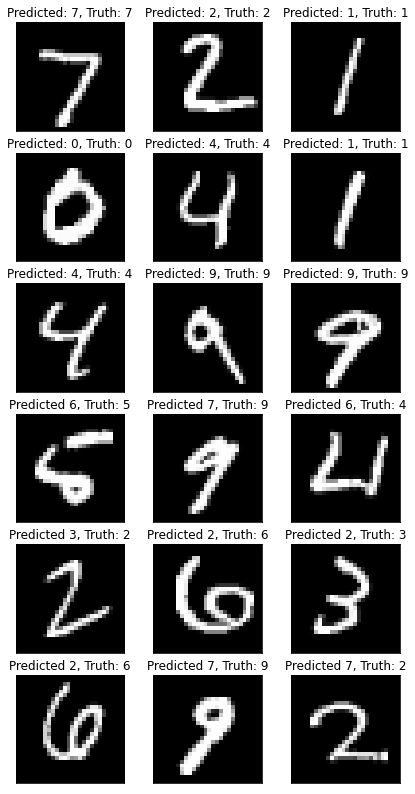

In [40]:
# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(y_pred[correct],
                                        y_test0[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(y_pred[incorrect], 
                                       y_test0[incorrect]))
    plt.xticks([])
    plt.yticks([])

# figure_evaluation

## 모형의 저장

>  트레이닝이 끝난 모형은 save 메서드로 가중치와 함께 hdf5 형식으로 저장하였다가 나중에 load 명령으로 불러 사용할 수 있다.

In [41]:
model.save('model_NN_2layers_good.hdf5')
# del model

In [42]:
from keras.models import load_model

model2 = load_model('model_NN_2layers_good.hdf5')
model2.predict(X_test[:1, :], verbose=0)
np.argmax(model2.predict(X_test[:1, :], verbose=0),axis=1)

array([7])

In [43]:
# Predict of the first 10 test data
np.argmax(model2.predict(X_test[:10, :], verbose=0),axis=1)

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9])

### 저장된 모형을 이용하여 테스트 데이터에 대한 예측 정확도 계산 

In [45]:
# Wrong prediction
np.argmax(model2.predict(X_test[8:9, :], verbose=1),axis=1)

1/1 [==============================] - 0s 3ms/step


array([6])

In [46]:
y_test0[8]  # Compare the true value and the prediction.

5

In [48]:
# 전체 테스트 데이터에 대한 예측
x_pred = np.argmax(model2.predict(X_test, verbose=1, batch_size=100), axis=1)

100/100 [==============================] - 0s 1ms/step


In [49]:
t_count = np.sum(x_pred==y_test0) # True positive
f_count = np.sum(x_pred!=y_test0) # False positive
f_count==10000-t_count

True

In [50]:
t_count,f_count

(8917, 1083)

In [51]:
accuracy = t_count/10000*100
accuracy

89.17

### 모델 성능 평가
- model.evaluate(X_test, y_test, batch_size)

In [52]:
model.evaluate(X_test, y_test, batch_size=100)

100/100 [==============================] - 0s 2ms/step - loss: 0.4481 - accuracy: 0.8917


[0.4480660557746887, 0.891700029373169]

In [53]:
model2.evaluate(X_test, y_test, batch_size=100)

100/100 [==============================] - 0s 2ms/step - loss: 0.4481 - accuracy: 0.8917


[0.4480660557746887, 0.891700029373169]

### Accuracy of predicting test numbers is around 89.17% in the good neural network model.

> How to improve this model to the best model?
- Change loss function
- Change optimizer
- Change activation
- Change the number of neurons 
- Add new layers
- Apply Dropout
- ...



---

